# Mini Project 4

**2025 Introduction to Quantiative Methods in Finance**

**The Erdös Institute**

In the lectures we explored how to delta hedge sold call options, resulting in a trading strategy whose profits are neutral to upward or downward drift in a stock path movements, provided the volatility, or $\sigma$, of the stock remained constant.

For this final mini project explore the impact of a non-constant $\sigma$ on the distribution of profits of hedging. You are also encouraged to explore/research a $\sigma$-hedging strategy and write code that simulates the profit distribution of the $\sigma$-hedging strategy. 

Below is some code you can customize that simulates a stock path whose $\sigma$ is not constant.

You are encouraged to use a different model for sigma then the one provided. You can use stock paths simulated by Heston model? You could use a GARCH model for volatility. The choice is yours and you can do your own research to choose how to model a stock movement. 

In [1]:
#Package Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

In [2]:
def stock_path_custom_sigma(S0, t, r, mu, n_paths, n_steps):
    '''
    Generation of custom stock paths following Geometeric Brownian motion,
    but log-returns do not have constant volatility.
    
    Each step of the log-returns, there is a 
    1) 50% the volatility is .2
    2) 30% chance the volatility is .3
    3) 20% chance the volatility is .45
    
    Inputs:
    S0 (float): initial stock value
    t (float): time interval of stock path movements in years
    r (float): risk-free interest rate
    mu (float): drift of log-returns
    n_paths (int): number of stock paths
    n_steps (float): number of steps in each stock path
    
    Returns:
    
    Simuatled stock paths
    '''
    
    #Noise in volatility
    noise = np.random.normal(0,1,size = (n_paths, n_steps))
    
    #Custom sigma that is not constant
    sigma = np.random.choice([.2,.3,.45], p = [.5, .3, .2], size = (n_paths, n_steps))
    
    #Time increment between each step
    dt = t/n_steps
    
    #log-returns between each step
    increments = (mu + r - .5*sigma**2)*dt + sigma*np.sqrt(dt)*noise
    
    #Cumulative log-returns at each step
    log_returns = np.cumsum(increments, axis = 1)
    
    
    #paths
    paths = S0*np.exp(log_returns)
    
    
    #Adjoint initial value S0 at start of each simulated path
    paths = np.insert(paths, 0, S0, axis = 1)
    
    
    return paths
    
    

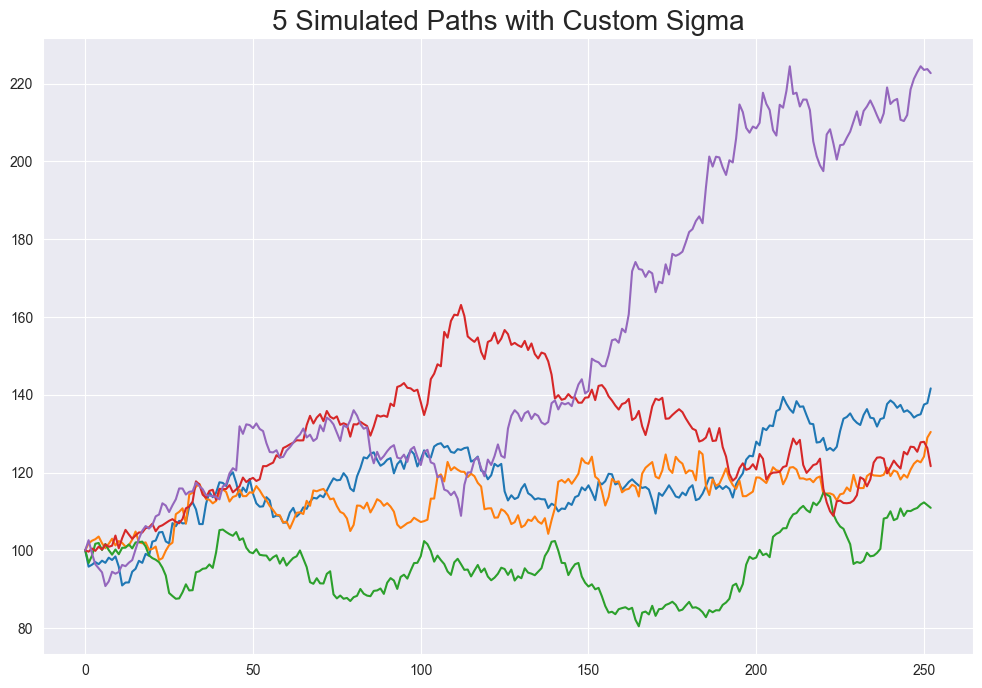

In [3]:
#5 Simulated paths of daily steps over 1-year period and plot

S0 = 100
t = 1
r = 0.039
mu = 0.275
n_paths = 5
n_steps = 252


simulated_paths = stock_path_custom_sigma(S0, t, r, mu, n_paths, n_steps)


plt.figure(figsize = (12,8))

for path in simulated_paths:
    plt.plot(path)
    
plt.title(f'{n_paths} Simulated Paths with Custom Sigma', size = 20)


plt.show()

In [ ]:
#GARCH implementation
from arch import arch_model

def simulate_GARCH_sigma(n_steps, omega=1e-6, alpha=0.05,beta=0.94):
    """
    Builds length n time series of spot volailities using GARCH(1,1). 
    Returns spot volatility at each step. 
    """
    sigma2 = np.ones(n_steps)*omega/(1-alpha-beta)
    eps = np.zeros(n_steps)
    for t in range(1, n_steps):
        eps[t-1] = np.sqrt(sigma2[t-1]) * np.random.randn()
        sigma2[t] = omega + alpha*eps[t-1]**2 +beta*sigma2[t-1]
    return np.sqrt(sigma2)

def one_path(S0, T, r, mu, n_steps):
    """
    Get a vector of sigmas from simulate GARCH sigma and then simulates delta log St
    we obtain S_t from this. 
    """
    dt = T/n_steps
    sigma_path = simulate_GARCH_sigma(n_steps)
    noise = np.random.randn(n_steps)
    # compute log‐increments and S
    increments = (mu - 0.5*sigma_path**2)*dt + sigma_path*np.sqrt(dt)*noise
    logret = np.cumsum(increments)
    S = np.exp(np.insert(logret, 0, 0))*S0
    return S, sigma_path



In [ ]:
import numpy as np
from scipy.stats import norm

def bs_price_delta(S, K, tau, r, sigma):
    #compute BS call price, computes BS delta. returns call price and delta. 
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*tau)/(sigma*np.sqrt(tau))
    d2 = d1 - sigma*np.sqrt(tau)
    call = S*norm.cdf(d1) - K*np.exp(-r*tau)*norm.cdf(d2)
    delta = norm.cdf(d1)
    return call, delta

def simulate_hedge(S_paths, sigma_paths, K, r, dt, sigma_assumed, strategy='constant'):
    """
    For each simulated path i:
        Initialize cash = BS_price(S₀; σ_assumed)
      • Loop for n-1 steps:
        Compute delta either with sigma_assumed (“constant”) or sigma_true[t] (“sigma-hedge”)
        Rebalance: buy/sell shares, update cash at r
      • At T: liquidate shares, pay option payoff
      • Store P&L = final cash
    Returns array of P&L over all paths.
    """
    n_paths, n_steps = S_paths.shape[0], S_paths.shape[1]-1
    pnl = np.zeros(n_paths)
    for i in range(n_paths):
        S = S_paths[i]
        sigma_true = sigma_paths[i]
        cash = bs_price_delta(S[0],K,(n_steps)*dt,r,sigma_assumed)[0]  
        shares = 0
        for t in range(n_steps):
            tau = (n_steps - t)*dt
            if strategy=='constant':
                _, delta = bs_price_delta(S[t],K,tau,r,sigma_assumed)
            else:
               
                sigma_forecast = sigma_true[t]  
                _, delta = bs_price_delta(S[t],K,tau,r,sigma_forecast)
         
            cash -= (delta - shares)*S[t]
            shares = delta
            cash *= np.exp(r*dt)  
        cash += shares*S[-1] - max(S[-1]-K,0)
        pnl[i] = cash
    return pnl


In [ ]:
#simulation of paths
n_paths  = 1000
n_steps  = 252
S0, T, r, mu = 100, 1.0, 0.039, 0.275

# pre‐allocate
S_paths = np.zeros((n_paths, n_steps+1))
sigma_paths = np.zeros((n_paths, n_steps))

for i in range(n_paths):
    S_paths[i], sigma_paths[i] = one_path(S0, T, r, mu, n_steps)



In [14]:
dt = T/n_steps
pnl_const = simulate_hedge(
    S_paths, sigma_paths,
    K=100, r=0.039, dt=dt,
    sigma_assumed=0.2, strategy='constant'
)

pnl_sigma = simulate_hedge(
    S_paths, sigma_paths,
    K=100, r=0.039, dt=dt,
    sigma_assumed=0.2, strategy='sigma-hedge'
)


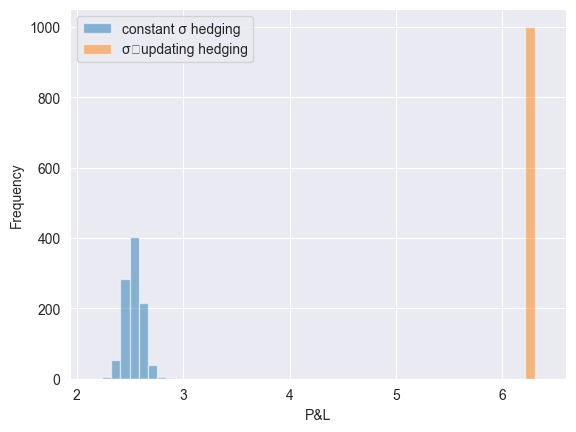

In [ ]:
import numpy as np

bins = np.linspace(
    min(pnl_const.min(), pnl_sigma.min()) - 0.1,
    max(pnl_const.max(), pnl_sigma.max()) + 0.1,
    50,
)

plt.hist(pnl_const, bins=bins, alpha=0.5, label='constant σ hedging')
plt.hist(pnl_sigma,  bins=bins, alpha=0.5, label='σ‐updating hedging')
plt.legend()
plt.xlabel("P&L")
plt.ylabel("Frequency")
plt.show()


if we know tomorrow's sigma, we can earn a risk free arbtirage of 6.29 per contract. however, our P and L is around 2.5 since we have hedging errors. we priced the call at sigma_assumed = 0.2, but the true path by path volatility wanders, which leave us with random gains or losses. however, if we have a constant P and L of 6.29(no deviations from this point) we are doing a perfect continuous time local hedge. we eliminate the volatility risk of the call. 